## Mapping and Image Analysis: Finding Kansas Lakes 

Rasters: Pixels, arrays, images - typically use Rasterio

Vectors: points, lines, polygons - typically use Geopandas 

In [85]:
# Import modules
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import area_opening,binary_closing, disk
from skimage.measure import find_contours, label, regionprops_table
import pandas as pd

In [2]:
# Read the GeoTiff file

filename = 'snapshot-2022-02-14.tiff'
raster = rasterio.open(filename)

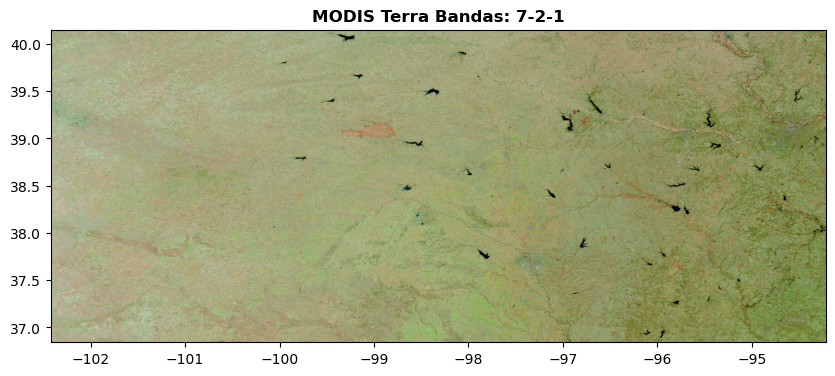

In [3]:
# Display the map 
plt.figure(figsize = (10, 5))
show(raster, title = 'MODIS Terra Bandas: 7-2-1')
plt.show()

In [4]:
# Inspect some properties of the image 

print('Data type:', raster.dtypes)
print('Shape of the image:', raster.shape)
print('Image width:', raster.width)
print('Image height:', raster.height)
print('Bands:', raster.indexes)
print('Binding box', raster.bounds)
print('Missing values', raster.nodatavals)
print('CRS', raster.crs)

Data type: ('uint8', 'uint8', 'uint8')
Shape of the image: (1507, 2923)
Image width: 2923
Image height: 1507
Bands: (1, 2, 3)
Binding box BoundingBox(left=-102.4226948326131, bottom=36.841697080291986, right=-94.21669483261314, top=40.15269708029198)
Missing values (None, None, None)
CRS EPSG:4326


In [5]:
# Show raster metadata
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 2923,
 'height': 1507,
 'count': 3,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.002807389668149146, 0.0, -102.4226948326131,
        0.0, -0.0021970802919708, 40.15269708029198)}

In [6]:
raster.xy(row = 0, col = 0, offset = 'ul')

(-102.4226948326131, 40.15269708029198)

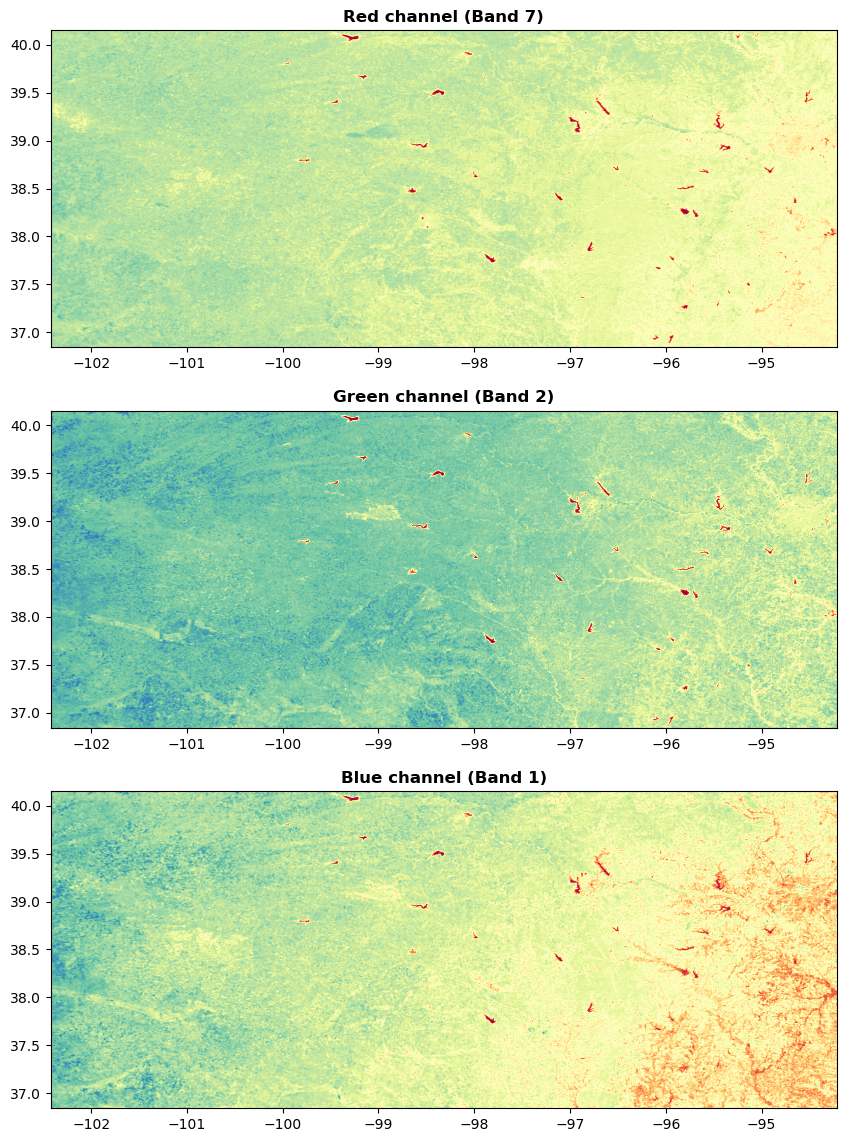

In [15]:
# plot all the bands 
fig, (ax_red, ax_green, ax_blue) = plt.subplots(3, 1, figsize = (12, 14))
show( (raster, 1), ax = ax_red, cmap = 'Spectral', title = 'Red channel (Band 7)')
show( (raster, 2), ax = ax_green, cmap = 'Spectral', title = 'Green channel (Band 2)')
show( (raster, 3), ax = ax_blue, cmap = 'Spectral', title = 'Blue channel (Band 1)')
plt.show()

In [32]:
# Inspect pixel values for a point 
lat = 39.100000
lon = -96.934662
py, px = raster.index(lon, lat)
pix_red = raster.read(1)[py, px]
pix_green = raster.read(2)[py, px]
pix_blue = raster.read(3)[py, px]
print(pix_red, pix_green, pix_blue)

1 0 4


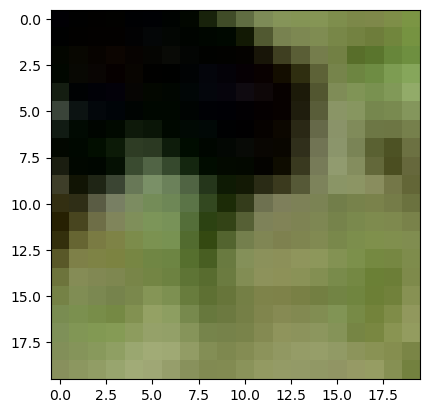

<AxesSubplot:>

In [45]:
#plot a small patch of land 
small_window = raster.read(window=rasterio.windows.Window(px, py, 20, 20))
show(small_window)

In [47]:
# Classify the lakes using threshold 
BW = raster.read(2) < 50

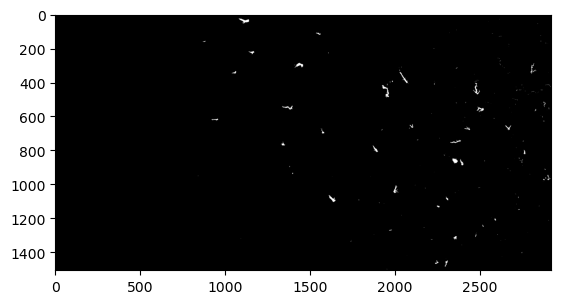

In [48]:
plt.figure()
plt.imshow(BW, cmap = 'gray')
plt.show()

In [54]:
# Percentage of area covered by lake 
print('Area of the state covered by the lakes:', BW.sum()/BW.size*100)

Area of the state covered by the lakes: 0.26338485176145715


In [64]:
# Area of water bodies 
pixel_area = 0.25* 0.25 # square kilometers 
print('Total Area with water bodies:', BW.sum() * pixel_area)

Total Area with water bodies: 725.125


In [65]:
# Save resulting BW array as a raster map 
profile = raster.profile 
profile.update(count = 1)
with rasterio.open('lakes.tiff', 'w', **profile) as f:
    f.write(BW, 1)

In [66]:
# Read the lakes Geotiff back into python 
lakes = rasterio.open('lakes.tiff')

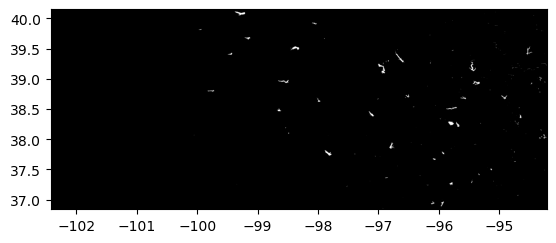

<AxesSubplot:>

In [67]:
show((lakes, 1), cmap = 'gray')

In [74]:
# Get the image out of the GeoTIff file
# and remove the additional band 
# Rasterio (band, row, column)
# Sckit Image (row, column, band)
print(lakes.read().shape)
BW = np.squeeze(lakes.read())
lakes.read().shape
print(BW.shape)

(1, 1507, 2923)
(1507, 2923)


In [76]:
# Filter image 
BW = area_opening(BW, area_threshold=100, connectivity=1)
BW = binary_closing(BW, disk(5))

In [77]:
# Find lake contours 
contours = find_contours(BW)
print('Detected:', len(contours), 'lakes')

Detected: 29 lakes


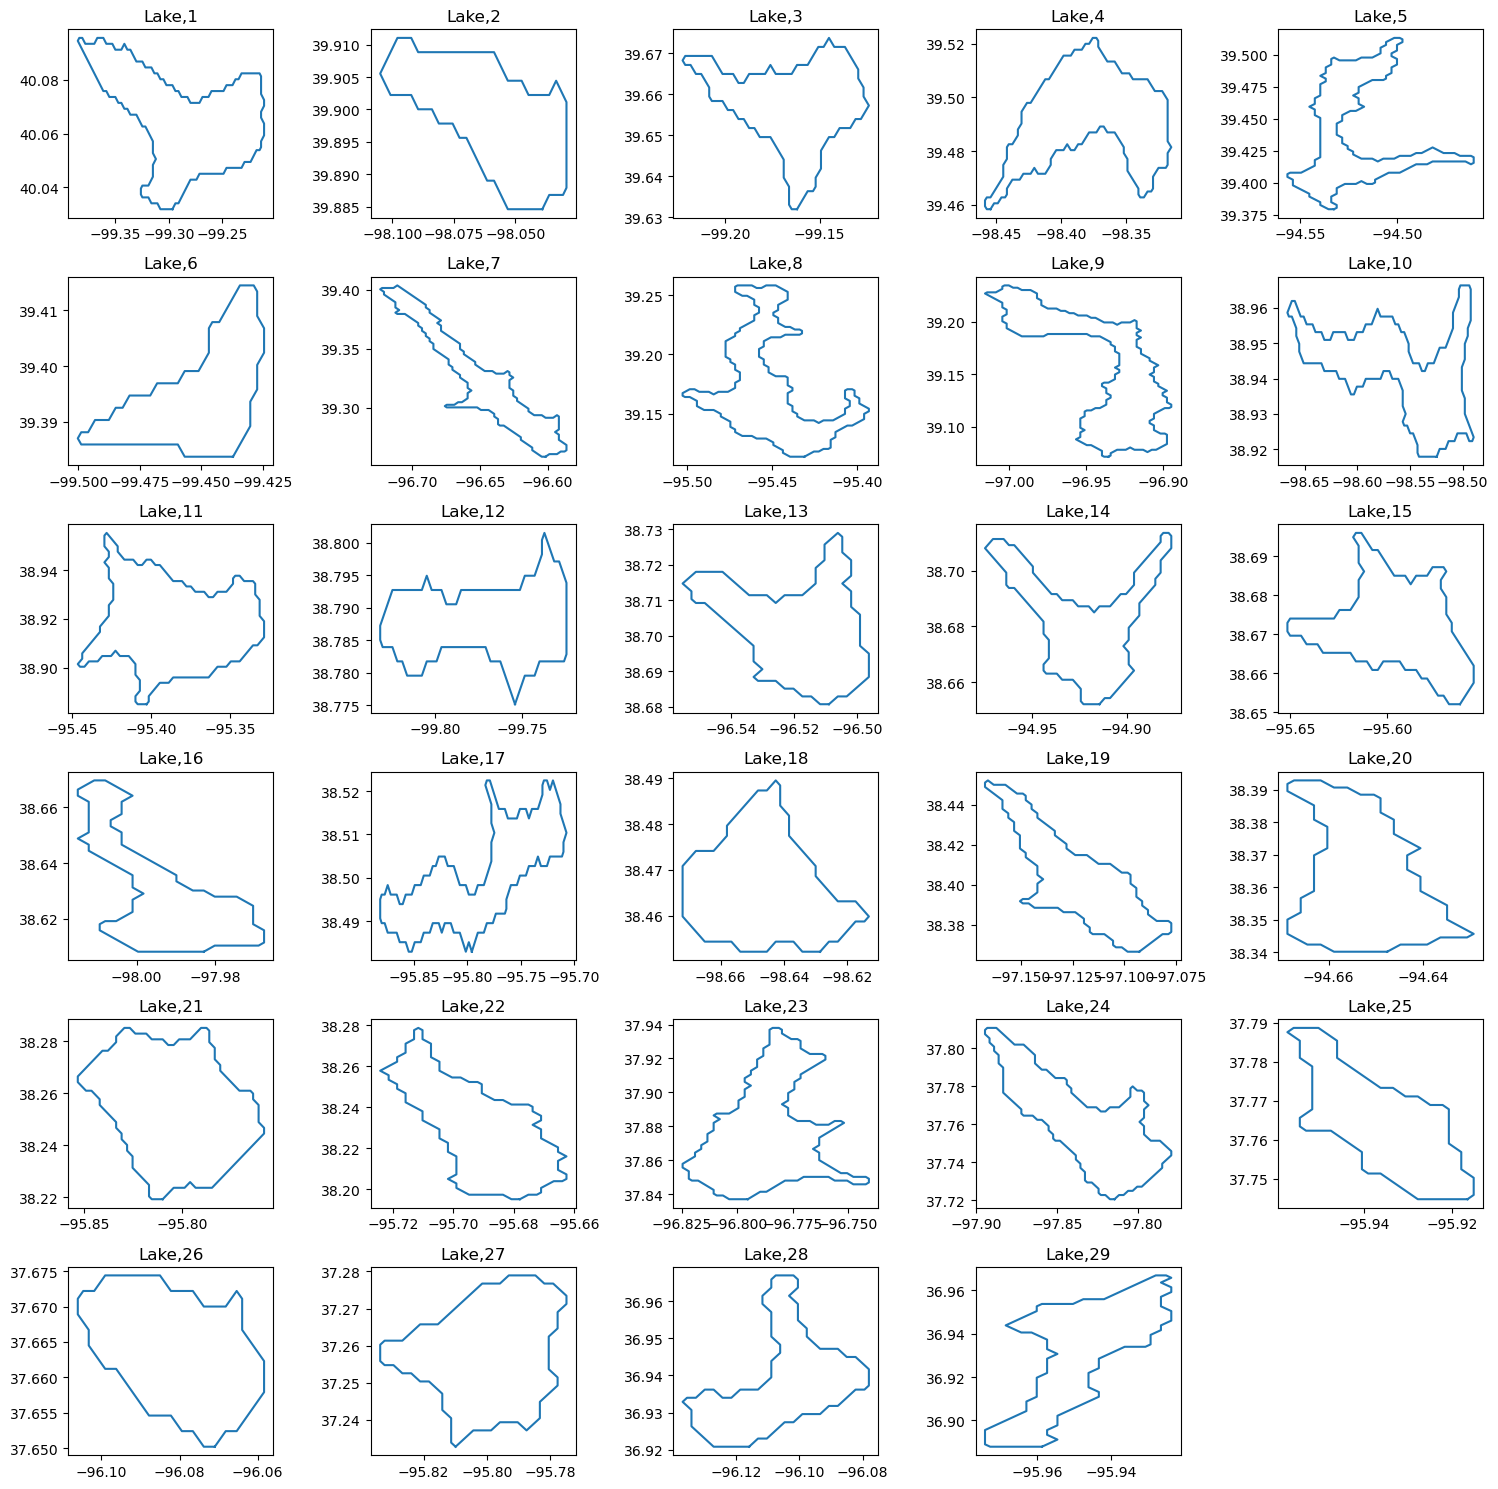

In [83]:
# Create a figure with the plot of each lake 
plt.figure(figsize = (15, 15))

for k in range(len(contours)): 
    plt.subplot(6, 5, k+1)
    plt.title(f'Lake,{str(k+1)}')
    lon, lat = lakes.xy(contours[k][:,0], contours[k][:,1])
    plt.plot(lon, lat)

plt.tight_layout()   
plt.show()

In [88]:
# Create table with properties for each lake 
props = regionprops_table(label(BW), properties=('centroid', 'area'))
props = pd.DataFrame(props)
props['area'] = props['area']*250*250/10_000 # hecters
props.head()


,centroid-0,centroid-1,area
0,39.569054,1116.222506,4887.50
1,115.117647,1553.352941,1062.50
2,225.279070,1160.348837,1612.50
3,300.310832,1440.237049,3981.25
4,323.678571,2813.549603,3150.00


In [89]:
# sort dataframe by area
props.sort_values(by = 'area', ascending = False, inplace = True)
props.head()

,centroid-0,centroid-1,area
8,455.403491,1951.932238,6087.50
7,445.782116,2482.799748,4962.50
0,39.569054,1116.222506,4887.50
3,300.310832,1440.237049,3981.25
10,561.560440,2506.014129,3981.25
